In [23]:
from data_multi import Bandit_multi
from learner_diag import NeuralUCBDiag
import numpy as np
import argparse
import pickle
import os
import time
import torch
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device
# torch.set_num_threads(8)
# torch.set_num_interop_threads(8)

device(type='cuda', index=0)

In [1]:


def truncated_gaussian(mean, variance, a, b, size):
    # Calculate the standard deviation from the variance
    std_dev = np.sqrt(variance)

    # Calculate the lower and upper bounds for truncation
    lower_bound = (a - mean) / std_dev
    upper_bound = (b - mean) / std_dev

    # Generate samples from the truncated normal distribution
    samples = truncnorm.rvs(lower_bound, upper_bound, loc=mean, scale=std_dev, size=size)

    return np.array(samples)


class Evaluation:

    def __init__(self, game_name, task, n_folds, horizon, game, label, context_type):
        self.game_name = game_name
        self.task = task
        self.n_folds = n_folds
        self.horizon = horizon
        self.game = game
        self.label =  label
        self.context_type = context_type
        

    def get_outcomes(self, game, ):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        context_generator, jobid = job

        np.random.seed(jobid)

        cumRegret =  np.zeros(self.horizon, dtype =float)
        compteur = None
        for t in range(self.horizon):
            compteur = t
            if t % 1000 == 0 :
                print(t)

            context,distribution = context_generator.get_context()
            outcome = np.random.choice( 2 , p = distribution )

            action = alg.get_action(t, context)

            print('t', t, 'action', action, 'outcome', outcome, 'dist', distribution,)
            print()
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret[t] =  val

        for c in range(compteur,self.horizon):
            cumRegret[c] = np.nan

        return cumRegret
    


class ToyContexts:

    def __init__(self, ):
        self.type = 'toy'
        self.d_context = 2

    def get_context(self, ):
        p = np.random.uniform(0.4, 0.6) 
        return np.array([1,p]).reshape(2,1), [p, 1-p]


In [2]:
import neuralcbpside_v1
import games
import synthetic_data
import numpy as np
import geometry_v3
import cbpside

horizon = 100
lbd = 0.01
game = games.apple_tasting( )

# w = np.array([0, 1])
# context_generator = ToyContexts(  )

size = 5
w = np.array([0.2]*size)
context_generator1 = LinearContexts( w )

alg1 = neuralcbpside_v1.NeuralCBPside2(game, len(w), 1.01, lbd, 5 )
# alg2 = cbpside.CBPside( game, len(w), 1.01, lbd )

eval1 = Evaluation(None, None, None, horizon, game, None, None)
job1 = context_generator1, 0
cumRegret1 = eval1.eval_policy_once(alg1, game, job1)

# eval2 = Evaluation(None, None, None, horizon, game, None, None)
# job2 = context_generator2, 0
# cumRegret2 = eval2.eval_policy_once(alg2, game, job2)

Restricted license - for non-production use only - expires 2024-10-28
0
t 0 action 0 outcome 0 dist [0.8263623687708199, 0.17363763122918008]

t 1 action 1 outcome 1 dist [0.8496372488395842, 0.15036275116041575]

action 1 torch.Size([36])
action 2 torch.Size([42])
confidence [array(0.8909619, dtype=float32), array(0.3685043, dtype=float32)]
estimates [array([[0.43093258]], dtype=float32), array([[0.51522547],
       [0.09229584]], dtype=float32)]
pair [0, 1] tdelta -0.42292962968349457 confidence 0.5211437587884762
pair [1, 0] tdelta 0.42292962968349457 confidence 0.5211437587884762
t 2 action 1 outcome 1 dist [0.26804882535483343, 0.7319511746451666]

action 1 torch.Size([36])
action 2 torch.Size([42])
confidence [array(1.7967207, dtype=float32), array(0.57632524, dtype=float32)]
estimates [array([[0.9690092]], dtype=float32), array([[0.818027  ],
       [0.03344373]], dtype=float32)]
pair [0, 1] tdelta -0.784583292901516 confidence 0.8150469675653728
pair [1, 0] tdelta 0.78458329290

/home/mheuillet/Desktop/neuralcbpside/neuralcbpside_v1.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  width2 = (g.T @ self.functionnal[i]['Z_it_inv'] @ g) / self.functionnal[i]['m']
/home/mheuillet/Desktop/neuralcbpside/.venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action 1 torch.Size([36])
action 2 torch.Size([42])
confidence [array(1.8799099, dtype=float32), array(0.39889893, dtype=float32)]
estimates [array([[0.86541647]], dtype=float32), array([[0.73378664],
       [0.23920642]], dtype=float32)]
pair [0, 1] tdelta -0.4945802241563797 confidence 0.5641282759135243
pair [1, 0] tdelta 0.4945802241563797 confidence 0.5641282759135243
t 5 action 1 outcome 0 dist [0.7245171384461814, 0.2754828615538186]

action 1 torch.Size([36])
action 2 torch.Size([42])
confidence [array(2.0760798, dtype=float32), array(0.24742699, dtype=float32)]
estimates [array([[0.92161626]], dtype=float32), array([[0.64090466],
       [0.34385225]], dtype=float32)]
pair [0, 1] tdelta -0.29705241322517395 confidence 0.34991460028023724
pair [1, 0] tdelta 0.29705241322517395 confidence 0.34991460028023724
t 6 action 1 outcome 0 dist [0.7422705630120976, 0.2577294369879024]

action 1 torch.Size([36])
action 2 torch.Size([42])
confidence [array(1.2340255, dtype=float32), array(0

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
_ = torch.manual_seed(0)

class Network(nn.Module):
    def __init__(self, output_dim, dim, hidden_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_dim)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

func = Network( 1, 5, 5 )

# Create a tensor representing the input variables
x = torch.tensor([2.0, 3.0, 1.0, 1.0, 0.5], requires_grad=True)

pred = func(x)

func.zero_grad()

pred.backward()

# Access the gradient
gradient = x.grad

print(gradient)

g = torch.cat([p.grad.flatten().detach() for p in func.parameters()])

print(g, len(g))

total_params = sum( p.numel() for p in func.parameters() if p.requires_grad)
total_params

tensor([-0.0078, -0.1558,  0.1105, -0.0575,  0.1083])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7728,  1.1592,  0.3864,
         0.3864,  0.1932,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4117,
        -0.6176, -0.2059, -0.2059, -0.1029, -0.6249, -0.9373, -0.3124, -0.3124,
        -0.1562,  0.0000,  0.3864,  0.0000, -0.2059, -0.3124,  0.0000,  0.9923,
         0.0000,  0.1498,  1.5323,  1.0000]) 36


36

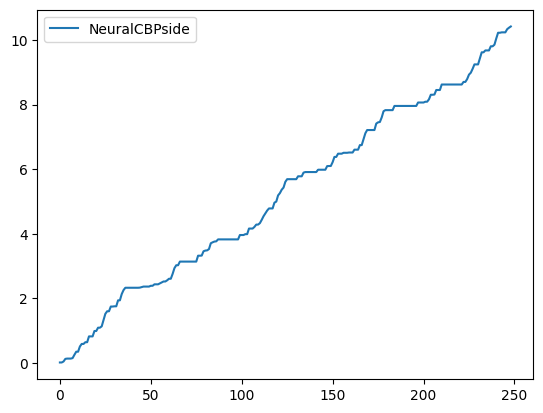

In [14]:

plt.plot(range(horizon), np.cumsum(cumRegret1), label = 'NeuralCBPside' )
# plt.plot(range(horizon), np.cumsum(cumRegret2), label = 'CBPside' )
plt.legend()
# plt.xlim(0,10)

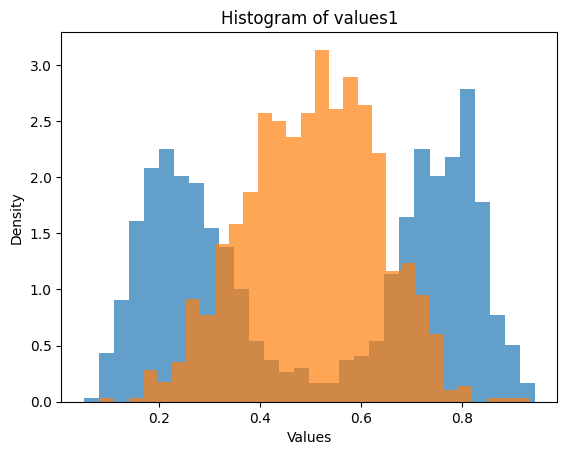

In [50]:
#### linear task:

class LinearContexts:
    def __init__(self,  w, task):
        self.d = len(w) # number of features
        self.w = w
        self.type = 'linear'
        self.task = task
    
    def get_context(self, ):

        if self.task == 'balanced':
            context = truncated_gaussian(0, 0.1, 0, 1, size) if np.random.uniform(0,1)<0.5 else truncated_gaussian(1, 0.1, 0, 1, size)
        else:
            context = truncated_gaussian(0.5, 1, 0, 1, size)
        cont = np.array(context).reshape(self.d,1)
        val = self.w @ cont
        val = [ val[0], 1-val[0] ]
        return cont, val 

size = 5
w = np.array([0.2]*size)
balanced, imbalanced = LinearContexts(w, 'balanced') ,LinearContexts(w, 'imbalanced')
values1, values2 = [], []    
for _ in range(1000):
    cont1, dist1 = balanced.get_context()
    values1.append( dist1[0] )

    cont2, dist2 = imbalanced.get_context()
    values2.append( dist2[0] )
    # values2.append( w @ balanced.get_context() )

plt.hist(values1, bins=30, density=True, alpha=0.7)
plt.hist(values2, bins=30, density=True, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of values1')
plt.show()

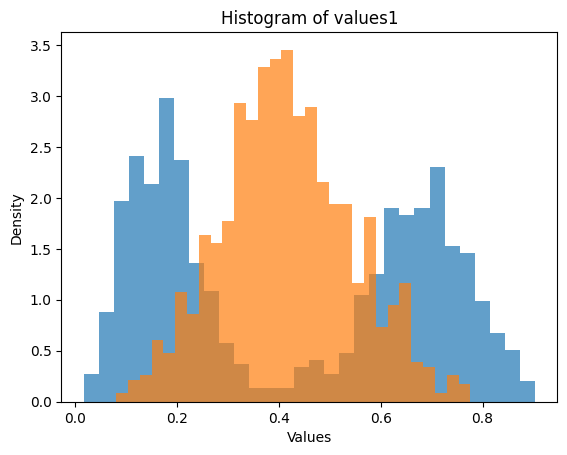

In [104]:
#### quadratic task:

class QuadraticContexts:
    def __init__(self,  w, task):
        self.d = len(w) # number of features
        self.w = w
        self.type = 'quadratic'
        self.task = task
    
    def get_context(self, ):

        if self.task == 'balanced':
            context = truncated_gaussian(0, 0.1, 0, 1, size) if np.random.uniform(0,1)<0.5 else truncated_gaussian(1, 0.1, 0, 1, size)
        else:
            context = truncated_gaussian(0.5, 1, 0, 1, size)
            
        cont = np.array(context).reshape(self.d,1)
        val = self.w @ cont**2 + self.w @ cont
        val = [ val[0], 1-val[0] ]
        return cont, val 

size = 5
w = np.array([0.1]*size)

# w = np.array([0.1]*size)
# cont = np.ones( size ) 
# w @ cont**2 + w @ cont 

balanced, imbalanced = QuadraticContexts(w, 'balanced') ,QuadraticContexts(w, 'imbalanced')
values1, values2 = [], []    
for _ in range(1000):
    cont1, dist1 = balanced.get_context()
    values1.append( dist1[0] )

    cont2, dist2 = imbalanced.get_context()
    values2.append( dist2[0] )
    # values2.append( w @ balanced.get_context() )

plt.hist(values1, bins=30, density=True, alpha=0.7)
plt.hist(values2, bins=30, density=True, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of values1')
plt.show()

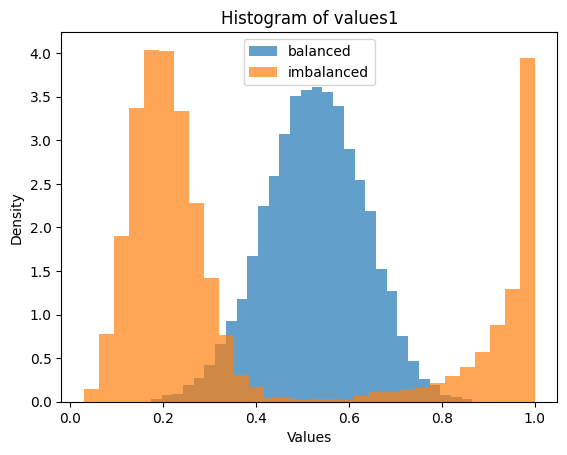

In [295]:
#### sinusoidal task:

class CosineContexts:
    def __init__(self,  w, task):
        self.d = len(w) # number of features
        self.w = w
        self.type = 'sinusoidal'
        self.task = task
    
    def get_context(self, ):

        if self.task == 'imbalanced':
            if np.random.uniform(0,1)<0.725:
                context = truncated_gaussian(np.pi/self.d**2, 0.05, 0, np.pi, self.d) if np.random.uniform(0,1)<0.5 else  truncated_gaussian(0, 0.05, 0, np.pi, self.d)
            else :
                context = truncated_gaussian(np.pi/2, self.d * np.pi, 0, np.pi, self.d)
                
        
        else:
            context = truncated_gaussian(np.pi/6, 0.1, 0, np.pi, self.d) if np.random.uniform(0,1)<0.5 else  truncated_gaussian(5 * np.pi / 6, 0.1, 0, np.pi, self.d)
        
        
        cont = np.array(context).reshape(self.d,1)
        val = np.sin(w@cont)
        val = [ val[0], 1-val[0] ]
        return cont, val 

size = 5
w = np.array([1/size]*size)

balanced, imbalanced = CosineContexts(w, 'balanced') ,CosineContexts(w, 'imbalanced')
values1, values2 = [], []    
for _ in range(10000):
    cont1, dist1 = balanced.get_context()
    values1.append( dist1[0] )

    cont2, dist2 = imbalanced.get_context()
    values2.append( dist2[0] )

plt.hist(values1, bins=30, density=True, alpha=0.7, label = 'balanced')
plt.hist(values2, bins=30, density=True, alpha=0.7, label = 'imbalanced')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of values1')
plt.show()